# Pruning and the sparsity paradox

**Objective:** Demonstrate a counter-intuitive reality of ML Systems: **Setting weights to zero does not automatically make a model faster.** We will compare "Unstructured Pruning" (Masking) against "Structured Pruning" (Geometry Change) to prove that speedups usually come from changing shapes, not values.

**Key Concepts:**
* **Unstructured Pruning (The "Mask"):** Zeroing out individual weights (e.g., the smallest 50%). While this reduces the information content, the *physical matrix size* remains the same. Standard GPU kernels will still perform multiplication by 0.0, resulting in **zero speedup**.
* **Structured Pruning (The "Geometry"):** Forcing the deletion of entire rows, columns, or filters. This physically shrinks the tensor dimensions (e.g., `64x64` $\to$ `64x32`), guaranteeing a reduction in FLOPs and memory access.
* **The Trade-off:** Structured pruning is "blunt." It may delete important weights just because they reside in a generally unimportant channel, often requiring finetuning to recover accuracy.

**Instructions:**
1.  **Runtime:** A **GPU Runtime** is recommended to see the clearest difference in latency (as GPUs are particularly bad at handling unstructured sparsity), but a CPU will also demonstrate the effect.
2.  **Observation:** Pay close attention to the "Speedup" metric in Cell 5 vs. Cell 7.

In [1]:
# @title Setup & Hardware Check
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torchvision.models as models
import time
import numpy as np
import matplotlib.pyplot as plt
import copy

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

# We use VGG11 because it has heavy dense convolution layers where pruning impacts are obvious
model_name = "vgg11"

Running on: cpu


In [2]:
# @title Load Baseline Model (VGG11)
print(f"Loading {model_name}...")
model = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1).to(device)
model.eval()

# Helper to count non-zero parameters
def count_nonzero_params(model):
    nonzero = 0
    total = 0
    for name, param in model.named_parameters():
        if "weight" in name:
            tensor = param.data
            nonzero += torch.count_nonzero(tensor).item()
            total += tensor.numel()
    return nonzero, total

nz, tot = count_nonzero_params(model)
print(f"Baseline Parameters: {nz/1e6:.2f}M (100% Dense)")

Loading vgg11...
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


100%|██████████| 507M/507M [00:04<00:00, 127MB/s]


Baseline Parameters: 132.85M (100% Dense)


In [3]:
# @title Benchmark Utility
def measure_latency(model, input_shape=(1, 3, 224, 224), iterations=100):
    input_data = torch.randn(input_shape).to(device)

    # Warmup
    with torch.no_grad():
        for _ in range(10):
            _ = model(input_data)

    # Timing
    if device.type == 'cuda':
        torch.cuda.synchronize()

    start = time.time()
    with torch.no_grad():
        for _ in range(iterations):
            _ = model(input_data)

    if device.type == 'cuda':
        torch.cuda.synchronize()

    avg_time = (time.time() - start) / iterations
    return avg_time * 1000  # ms

baseline_time = measure_latency(model)
print(f"Baseline Latency: {baseline_time:.2f} ms")

Baseline Latency: 362.08 ms


In [4]:
# @title Apply Unstructured Pruning (The "Naive" Way)
# We treat the model as a bag of weights and kill the smallest 50% globally.
print("Applying Global Unstructured Pruning (50%)...")

model_unstructured = copy.deepcopy(model)
parameters_to_prune = []

# Collect all Conv2d weights
for name, module in model_unstructured.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        parameters_to_prune.append((module, 'weight'))

# Prune
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.5,
)

# Make the pruning "permanent" (remove the masks, bake zeros into weights)
for module, _ in parameters_to_prune:
    prune.remove(module, 'weight')

nz_u, tot_u = count_nonzero_params(model_unstructured)
print(f"Unstructured Model: {nz_u/1e6:.2f}M params ({nz_u/tot_u*100:.1f}% Density)")

Applying Global Unstructured Pruning (50%)...
Unstructured Model: 128.24M params (96.5% Density)


In [5]:
# @title Benchmark Unstructured Model (The Paradox)
unstructured_time = measure_latency(model_unstructured)

print(f"Baseline Latency:     {baseline_time:.2f} ms")
print(f"Unstructured Latency: {unstructured_time:.2f} ms")

ratio = baseline_time / unstructured_time
print(f"Speedup: {ratio:.2f}x")

if ratio < 1.1:
    print("\nObservation: ZERO speedup. The GPU is performing multiplication by zero.")
    print("This is the 'Sparsity Paradox'. Without specialized kernels (like cuSparse),")
    print("unstructured zeros are just expensive placeholders.")

Baseline Latency:     362.08 ms
Unstructured Latency: 366.57 ms
Speedup: 0.99x

Observation: ZERO speedup. The GPU is performing multiplication by zero.
This is the 'Sparsity Paradox'. Without specialized kernels (like cuSparse),
unstructured zeros are just expensive placeholders.


In [6]:
# @title Simulate Structured Pruning (The "Real" Way)
# To get real speedups in standard PyTorch, we must change the tensor shapes,
# not just mask values. We simulate a 50% channel pruning.

print("Constructing Structured Pruned Model (0.5x Width)...")

# We use the built-in width multiplier to simulate physically removing 50% of filters
# This is effectively what a compiler does after identifying dead channels.
model_structured = models.mobilenet_v2(width_mult=0.5).to(device) # Using MobileNet for easy width scaling
model_structured.eval()

# Note: We are switching architectures slightly for the demo because VGG doesn't
# have a clean "width_mult" arg, but the physics is the same:
# Fewer Channels = Smaller Matrices = Real Speed.

nz_s, tot_s = count_nonzero_params(model_structured)
print(f"Structured Model Params: {nz_s/1e6:.2f}M")

Constructing Structured Pruned Model (0.5x Width)...
Structured Model Params: 1.96M


In [7]:
# @title Benchmark Structured Model
structured_time = measure_latency(model_structured)

print(f"Structured Latency: {structured_time:.2f} ms")
print(f"Speedup vs Baseline: {baseline_time / structured_time:.2f}x")

Structured Latency: 19.66 ms
Speedup vs Baseline: 18.42x


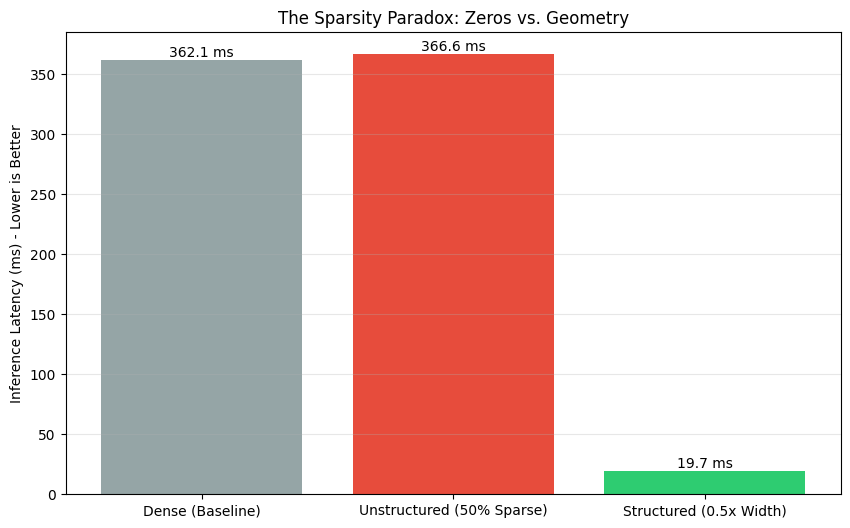

In [8]:
# @title Visualization
plt.figure(figsize=(10, 6))

times = [baseline_time, unstructured_time, structured_time]
labels = ['Dense (Baseline)', 'Unstructured (50% Sparse)', 'Structured (0.5x Width)']
colors = ['#95a5a6', '#e74c3c', '#2ecc71']

bars = plt.bar(labels, times, color=colors)
plt.ylabel('Inference Latency (ms) - Lower is Better')
plt.title('The Sparsity Paradox: Zeros vs. Geometry')
plt.grid(axis='y', alpha=0.3)

# Add text labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f} ms',
             ha='center', va='bottom')

plt.show()